In [1]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.preprocessing import LabelEncoder
import pickle
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

In [2]:
#unzip into /content/
#!unzip /content/drive/MyDrive/530_Project/TRAUMA_trinex.zip -d /content/

In [3]:
df = pd.read_csv('/content/CSV/PUF_TRAUMA.csv') # This is the main file


<ipython-input-3-a36db84fa3e1>:1: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/CSV/PUF_TRAUMA.csv') # This is the main file


In [4]:
df["AMERICANINDIAN"].value_counts() #Race columns are one-hot encoded

,count
AMERICANINDIAN,
0,1221824
1,11132


In [5]:
df.filter(regex="DISPOSITION", axis = 1 )

,EDDISCHARGEDISPOSITION,EDDISCHARGEDISPOSITION_BIU,HOSPDISCHARGEDISPOSITION,HOSPDISCHARGEDISPOSITION_BIU
0,8.0,NaN,6.0,NaN
1,NaN,1.0,6.0,NaN
2,3.0,NaN,10.0,NaN
3,3.0,NaN,6.0,NaN
4,3.0,NaN,6.0,NaN
...,...,...,...,...
1232951,1.0,NaN,6.0,NaN
1232952,9.0,NaN,NaN,1.0
1232953,2.0,NaN,6.0,NaN
1232954,8.0,NaN,5.0,NaN


In [6]:
df['EDDISCHARGEDISPOSITION'].value_counts()

,count
EDDISCHARGEDISPOSITION,
1.0,510845
8.0,203212
7.0,142587
9.0,124264
3.0,110399
2.0,45822
11.0,43366
5.0,12938
10.0,4124


In [7]:
df['HOSPDISCHARGEDISPOSITION'].value_counts(dropna = False)

,count
HOSPDISCHARGEDISPOSITION,
6.0,552179
NaN,189219
7.0,169238
11.0,113716
3.0,107922
5.0,33624
4.0,16737
8.0,14345
1.0,9608


In [8]:
df[ ['HOSPDISCHARGEDISPOSITION',"EDDISCHARGEDISPOSITION"]].isna().all(axis=1).value_counts()
#there are no patients with completely missing target data

,count
False,1232956


In [9]:
#create single column that gives a 1 if 5 is present in 'HOSPDISCHARGEDISPOSITION" or "EDDISCHARGEDISPOSITION"
df['Death'] = (df['HOSPDISCHARGEDISPOSITION'] == 5) | (df['EDDISCHARGEDISPOSITION'] == 5)

In [10]:
df['Death'].value_counts()

,count
Death,
False,1186394
True,46562


In [11]:
df['PRIMARYECODEICD10'].isna().value_counts()

,count
PRIMARYECODEICD10,
False,1231773
True,1183


In [12]:
df.ADDITIONALECODE1_BIU.value_counts(dropna= False)

,count
ADDITIONALECODE1_BIU,
1.0,1151664
2.0,43975
NaN,37317


In [13]:
df.ADDITIONALECODE2_BIU.value_counts(dropna= False)

,count
ADDITIONALECODE2_BIU,
NaN,1231782
1.0,1174


In [14]:
e_code_mapping = pd.read_csv('/content/CSV/PUF_ECODE_LOOKUP.csv')

In [15]:
e_code_mapping['TRAUMATYPE'].value_counts(dropna = False)

,count
TRAUMATYPE,
Blunt,1870
Penetrating,116
NaN,69
Burn,8


In [16]:
e_code_mapping['INTENT'].value_counts(dropna = False)

,count
INTENT,
Unintentional,1731
Other,188
Assault,95
Self-inflicted,29
Undetermined,20


In [17]:
e_code_mapping.loc[e_code_mapping['TRAUMATYPE'].isna(),'INTENT'].value_counts()

,count
INTENT,
Assault,56
Unintentional,13


In [18]:
e_code_mapping.loc[e_code_mapping['TRAUMATYPE'].isna() & (e_code_mapping['INTENT'] == "Assault"),]

,ECode,Ecode_Desc,INTENT,MECHANISM,TRAUMATYPE,ICD_VERSION
0,T74.11XA,"Adult physical abuse, confirmed, initial encou...",Assault,NaN,NaN,ICD10
1,T74.12XA,"Child physical abuse, confirmed, initial encou...",Assault,NaN,NaN,ICD10
3,T74.91XA,"Unspecified adult maltreatment, confirmed, ini...",Assault,NaN,NaN,ICD10
4,T74.92XA,"Unspecified child maltreatment, confirmed, ini...",Assault,NaN,NaN,ICD10
12,T76.11XA,"Adult physical abuse, suspected, initial encou...",Assault,NaN,NaN,ICD10
13,T76.12XA,"Child physical abuse, suspected, initial encou...",Assault,NaN,NaN,ICD10
14,T76.91XA,"Unspecified adult maltreatment, suspected, ini...",Assault,NaN,NaN,ICD10
15,T76.92XA,"Unspecified child maltreatment, suspected, ini...",Assault,NaN,NaN,ICD10
1803,Y07.01,"Husband, perpetrator of maltreatment and neglect",Assault,NaN,NaN,ICD10
1804,Y07.02,"Wife, perpetrator of maltreatment and neglect",Assault,NaN,NaN,ICD10


In [19]:
e_code_mapping.loc[e_code_mapping['TRAUMATYPE'].isna() & (e_code_mapping['INTENT'] == "Unintentional"),]

,ECode,Ecode_Desc,INTENT,MECHANISM,TRAUMATYPE,ICD_VERSION
1722,X34.XXXA,"Earthquake, initial encounter",Unintentional,"Natural/environmental, Other",NaN,ICD10
1723,X35.XXXA,"Volcanic eruption, initial encounter",Unintentional,"Natural/environmental, Other",NaN,ICD10
1724,X36.0XXA,Collapse of dam or man-made structure causing ...,Unintentional,"Natural/environmental, Other",NaN,ICD10
1726,X37.0XXA,"Hurricane, initial encounter",Unintentional,"Natural/environmental, Other",NaN,ICD10
1727,X37.1XXA,"Tornado, initial encounter",Unintentional,"Natural/environmental, Other",NaN,ICD10
1728,X37.2XXA,"Blizzard (snow)(ice), initial encounter",Unintentional,"Natural/environmental, Other",NaN,ICD10
1729,X37.3XXA,"Dust storm, initial encounter",Unintentional,"Natural/environmental, Other",NaN,ICD10
1730,X37.41XA,Tidal wave due to earthquake or volcanic erupt...,Unintentional,"Natural/environmental, Other",NaN,ICD10
1731,X37.42XA,"Tidal wave due to storm, initial encounter",Unintentional,"Natural/environmental, Other",NaN,ICD10
1732,X37.43XA,"Tidal wave due to landslide, initial encounter",Unintentional,"Natural/environmental, Other",NaN,ICD10


In [20]:
e_code_mapping.loc[e_code_mapping['TRAUMATYPE'].isna() & (e_code_mapping['INTENT'] == "Unintentional"),'TRAUMATYPE'] = "Storm Related"

In [21]:
e_code_mapping.loc[e_code_mapping['TRAUMATYPE'] == "Storm Related",]

,ECode,Ecode_Desc,INTENT,MECHANISM,TRAUMATYPE,ICD_VERSION
1722,X34.XXXA,"Earthquake, initial encounter",Unintentional,"Natural/environmental, Other",Storm Related,ICD10
1723,X35.XXXA,"Volcanic eruption, initial encounter",Unintentional,"Natural/environmental, Other",Storm Related,ICD10
1724,X36.0XXA,Collapse of dam or man-made structure causing ...,Unintentional,"Natural/environmental, Other",Storm Related,ICD10
1726,X37.0XXA,"Hurricane, initial encounter",Unintentional,"Natural/environmental, Other",Storm Related,ICD10
1727,X37.1XXA,"Tornado, initial encounter",Unintentional,"Natural/environmental, Other",Storm Related,ICD10
1728,X37.2XXA,"Blizzard (snow)(ice), initial encounter",Unintentional,"Natural/environmental, Other",Storm Related,ICD10
1729,X37.3XXA,"Dust storm, initial encounter",Unintentional,"Natural/environmental, Other",Storm Related,ICD10
1730,X37.41XA,Tidal wave due to earthquake or volcanic erupt...,Unintentional,"Natural/environmental, Other",Storm Related,ICD10
1731,X37.42XA,"Tidal wave due to storm, initial encounter",Unintentional,"Natural/environmental, Other",Storm Related,ICD10
1732,X37.43XA,"Tidal wave due to landslide, initial encounter",Unintentional,"Natural/environmental, Other",Storm Related,ICD10


In [22]:
e_code_mapping.loc[e_code_mapping['TRAUMATYPE'].isna(), 'TRAUMATYPE'] = e_code_mapping['Ecode_Desc'].apply(
    lambda x: 'terrorism' if pd.notna(x) and 'terrorism' in x.lower() else 'neglect or abuse'
)

In [23]:
e_code_mapping.TRAUMATYPE.value_counts(dropna=False) #fill in trauma type

,count
TRAUMATYPE,
Blunt,1870
Penetrating,116
neglect or abuse,42
terrorism,14
Storm Related,13
Burn,8


In [24]:
e_code_mapping.MECHANISM.value_counts()

,count
MECHANISM,
MVT Other,339
MVT Occupant,335
"Transport, Other",277
Other Specified and Classifiable,186
"Pedal Cyclist, Other",120
Fall,98
"Struck By, Against",97
"Natural/environmental, Other",90
MVT Motorcyclist,90


In [25]:
e_code_mapping.loc[e_code_mapping['MECHANISM'].isna(),'MECHANISM'] = "neglect or abuse"

In [26]:
#Map the PRIMARYECODEICD10 to the e_code_mapping
df = df.merge(e_code_mapping[['ECode', 'INTENT','TRAUMATYPE','MECHANISM']], left_on='PRIMARYECODEICD10', right_on='ECode', how='left')

In [27]:
df.loc[df.ECode.isna(),["ECode","PRIMARYECODEICD10"]].head()

,ECode,PRIMARYECODEICD10
92,NaN,X83.8XXA
214,NaN,Y09
439,NaN,Y08.89XA
696,NaN,Y33.XXXA
712,NaN,Y09


In [28]:
df.ECode.isna().value_counts()

,count
ECode,
False,1214635
True,18321


In [29]:
#drop the ecode NAs
df = df.dropna(subset=['ECode'])

In [30]:
#drop all BIU columns
df = df.drop(columns=df.columns[df.columns.str.contains('biu', case=False)].tolist())


In [31]:
df['Death'].value_counts() # see if this changes the death col , it doesnt

,count
Death,
False,1169353
True,45282


In [32]:
# Handle missing values for other columns
df = df.fillna(df.median(numeric_only=True))  # Fill numeric NaNs with median values

# Encode categorical variables
label_encoders = {}
for column in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column].astype(str))
    label_encoders[column] = le  # Save encoders for potential future use

In [33]:
# Define features (X) and target (y)
X = df.drop(columns=['HOSPDISCHARGEDISPOSITION', 'EDDISCHARGEDISPOSITION',
                     'Death','WITHDRAWALLST','TOTALGCS',"WITHDRAWALLSTDAYS","WITHDRAWALLSTHRS"])  # Drop target and irrelevant columns
y = df['Death']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Applying SMOTE to balance the dataset
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [34]:
# Train the model on resampled data
model = xgb.XGBClassifier( eval_metric='logloss', random_state=42)
model.fit(X_resampled, y_resampled)

# Evaluate the model
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for class 1 (Death)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba))

Accuracy: 0.9840240072120431
Classification Report:
               precision    recall  f1-score   support

       False       0.99      0.99      0.99    233854
        True       0.83      0.72      0.77      9073

    accuracy                           0.98    242927
   macro avg       0.91      0.86      0.88    242927
weighted avg       0.98      0.98      0.98    242927

ROC-AUC Score: 0.9798392390810917


Top Features and Their Importance:
GCSMOTOR: 19853.71875
GCSVERBAL: 6213.78125
HIGHESTACTIVATION: 1759.937744140625
TOTALVENTDAYS: 1639.595458984375
SUPPLEMENTALOXYGEN: 1469.5697021484375
GCSEYE: 1370.222900390625
PMGCSQ_VALID: 1335.2547607421875
SEX: 1281.02685546875
DRGSCR_CANNABINOID: 1209.0635986328125
GCSQ_SEDATEDPARALYZED: 1186.00244140625
PREHOSPITALCARDIACARREST: 1163.655517578125
TOTALICULOS: 919.7593383789062
VTEPROPHYLAXISTYPE: 899.8800659179688
ALCOHOLSCREEN: 890.5595092773438
ES_NA: 806.0965576171875
ICP_NA: 738.15966796875
PRIMARYMETHODPAYMENT: 737.0084228515625
TBIPUPILLARYRESPONSE: 721.748291015625
TBIGCSMOTOR: 657.2194213867188
TBIHIGHESTTOTALGCS: 574.357177734375
GCSQ_VALID: 551.0933227539062
DRGSCR_AMPHETAMINE: 512.5194091796875
INTERFACILITYTRANSFER: 501.6957092285156
ANGIOGRAPHY: 342.4175109863281
DRGSCR_NONE: 324.04644775390625
FINALDISCHARGEDAYS: 321.1786804199219
PMGCSQ_INTUBATED: 319.3199462890625
BLOOD4HOURS: 317.8299255371094
GCSQ_UK: 294.32659912109375
AgeYe

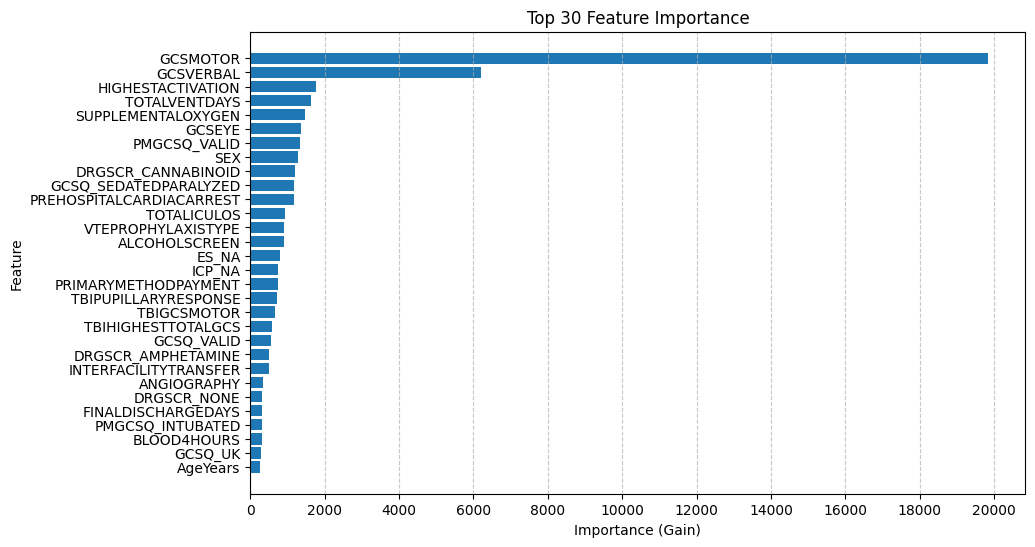

In [35]:
import matplotlib.pyplot as plt

# Get feature importance scores
importance = model.get_booster().get_score(importance_type='gain')  # 'gain', 'weight', or 'cover'

# Sort the features by importance
importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)

# Extract top 10 feature names and scores
top_n = 30  # Adjust this number to show more or fewer features
features = [f[0] for f in importance[:top_n]]
scores = [f[1] for f in importance[:top_n]]

# Display the most important features
print("Top Features and Their Importance:")
for feature, score in zip(features, scores):
    print(f"{feature}: {score}")

# Plot top feature importance
plt.figure(figsize=(10, 6))
plt.barh(features, scores, align='center')
plt.xlabel('Importance (Gain)')
plt.ylabel('Feature')
plt.title(f'Top {top_n} Feature Importance')

# Add grid with x-axis ticks every 2000
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.xticks(range(0, int(max(scores)) + 2000, 2000))  # Increment ticks by 2000

# Invert y-axis for highest importance at the top
plt.gca().invert_yaxis()
plt.show()

In [36]:
# Define features (X) and target (y)
X_resampled_red = X_resampled[['GCSMOTOR','GCSVERBAL','GCSEYE','PREHOSPITALCARDIACARREST','AgeYears','SEX','TRAUMATYPE',
        'SUPPLEMENTALOXYGEN','VTEPROPHYLAXISTYPE',"ISS","MECHANISM", "SBP","PULSEOXIMETRY"]]  # Only get the important columns


In [38]:
X_test_red = X_test[['GCSMOTOR','GCSVERBAL','GCSEYE','PREHOSPITALCARDIACARREST','AgeYears','SEX','TRAUMATYPE',
        'SUPPLEMENTALOXYGEN','VTEPROPHYLAXISTYPE',"ISS","MECHANISM", "SBP","PULSEOXIMETRY"]]

In [ ]:
# Initialize and train the XGBoost model
model_reduced = xgb.XGBClassifier(eval_metric='logloss', random_state=42)
model_reduced.fit(X_resampled_red, y_resampled)



In [39]:
# Evaluate the model
y_pred = model_reduced.predict(X_test_red)
y_pred_proba = model_reduced.predict_proba(X_test_red)[:, 1]  # Probabilities for class 1 (Death)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba))

Accuracy: 0.9776723048487818
Classification Report:
               precision    recall  f1-score   support

       False       0.98      0.99      0.99    233854
        True       0.77      0.57      0.66      9073

    accuracy                           0.98    242927
   macro avg       0.88      0.78      0.82    242927
weighted avg       0.98      0.98      0.98    242927

ROC-AUC Score: 0.94775413389379


Top Features and Their Importance:
GCSMOTOR: 8832.4609375
GCSEYE: 2079.163330078125
SUPPLEMENTALOXYGEN: 1776.420166015625
SEX: 1325.67822265625
GCSVERBAL: 753.0734252929688
PREHOSPITALCARDIACARREST: 734.5562133789062
VTEPROPHYLAXISTYPE: 559.3809204101562
ISS: 294.8556213378906
PULSEOXIMETRY: 240.7330780029297
AgeYears: 179.4564971923828


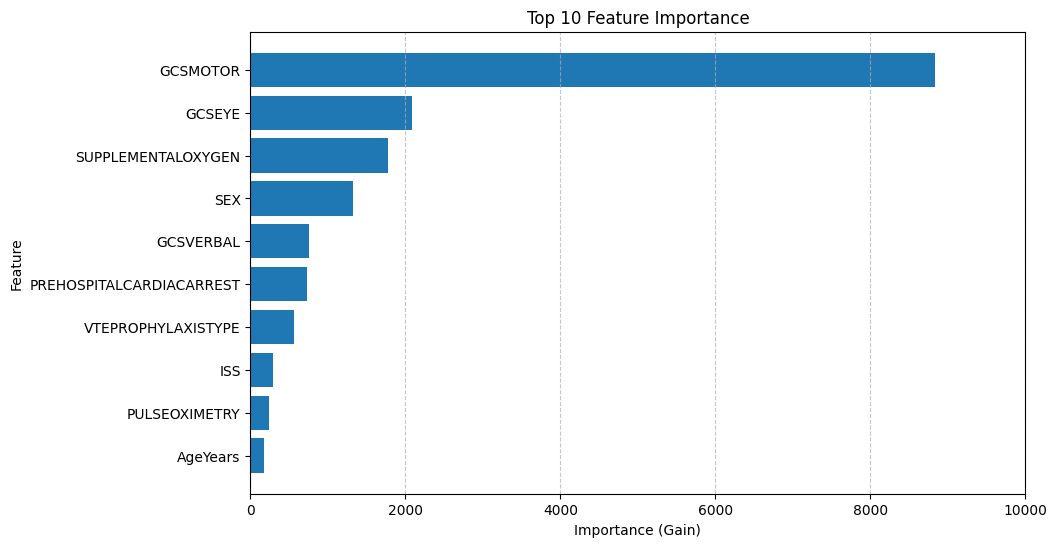

In [40]:
import matplotlib.pyplot as plt

# Get feature importance scores
importance = model_reduced.get_booster().get_score(importance_type='gain')  # 'gain', 'weight', or 'cover'

# Sort the features by importance
importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)

# Extract top 10 feature names and scores
top_n = 10  # Adjust this number to show more or fewer features
features = [f[0] for f in importance[:top_n]]
scores = [f[1] for f in importance[:top_n]]

# Display the most important features
print("Top Features and Their Importance:")
for feature, score in zip(features, scores):
    print(f"{feature}: {score}")

# Plot top feature importance
plt.figure(figsize=(10, 6))
plt.barh(features, scores, align='center')
plt.xlabel('Importance (Gain)')
plt.ylabel('Feature')
plt.title(f'Top {top_n} Feature Importance')

# Add grid with x-axis ticks every 2000
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.xticks(range(0, int(max(scores)) + 2000, 2000))  # Increment ticks by 2000

# Invert y-axis for highest importance at the top
plt.gca().invert_yaxis()
plt.show()

In [44]:
label_encoders['TRAUMATYPE'].classes_

array(['Blunt', 'Burn', 'Penetrating', 'Storm Related',
       'neglect or abuse', 'terrorism'], dtype=object)

In [43]:
label_encoders['MECHANISM'].classes_

array(['Cut/Pierce', 'Drowning/Submersion', 'Fall', 'Fire/Flame',
       'Firearm', 'MVT Motorcyclist', 'MVT Occupant', 'MVT Other',
       'MVT Pedal Cyclist', 'MVT Pedestrian', 'MVT Unspecified',
       'Machinery', 'Natural/environmental, Bites and Stings',
       'Natural/environmental, Other', 'Other Specified and Classifiable',
       'Overexertion', 'Pedal Cyclist, Other', 'Pedestrian, Other',
       'Struck By, Against', 'Transport, Other', 'neglect or abuse'],
      dtype=object)

In [45]:
# Save the trained model to a .pkl file
model_filename = 'xgboost_patient_death_predictor_percentage_reduced.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(model_reduced, file)

print(f"Model saved to {model_filename}")

# Save the label encoders (optional, if input variables need encoding on the website)
encoders_filename = 'label_encoders_percentage.pkl'
with open(encoders_filename, 'wb') as file:
    pickle.dump(label_encoders, file)

print(f"Encoders saved to {encoders_filename}")

Model saved to xgboost_patient_death_predictor_percentage_reduced.pkl
Encoders saved to label_encoders_percentage.pkl


In [ ]:
import pickle
import pandas as pd

In [48]:
# Step 1: Load the model and extract feature names
def load_model_and_features(model_path):
    # Load the trained model
    with open(model_path, 'rb') as file:
        model = pickle.load(file)

    # Extract feature names from the model
    feature_columns = model.get_booster().feature_names

    return model, feature_columns

# Step 2: Prepare the user input for prediction
def preprocess_input(user_input, feature_columns):
    # Convert user input to a DataFrame
    input_df = pd.DataFrame([user_input], columns=feature_columns)

    # Fill missing columns with default values (e.g., 0)
    for col in feature_columns:
        if col not in input_df.columns:
            input_df[col] = 0

    return input_df

# Step 3: Run inference
def predict_percentage(user_input, model, feature_columns):
    # Preprocess the input
    input_df = preprocess_input(user_input, feature_columns)

    # Run prediction to get probabilities
    prediction_proba = model.predict_proba(input_df)

    # Extract the probability of the positive class (death)
    probability_of_death = prediction_proba[0][1]  # Class 1 (Death)

    # Convert to percentage
    return probability_of_death * 100



In [50]:
model_path = 'xgboost_patient_death_predictor_percentage_reduced.pkl'

In [61]:
model, feature_columns = load_model_and_features(model_path)

# Example user input based on the feature columns
user_input = {'GCSMOTOR': 6,
              'GCSVERBAL': 6,
              'GCSEYE':6,
              'PREHOSPITALCARDIACARREST':2,
              'AgeYears':50,
              'SEX':1,
              'TRAUMATYPE':1,
              'SUPPLEMENTALOXYGEN':1,
              'VTEPROPHYLAXISTYPE':11,
              "ISS":100,
              "MECHANISM":1,
              "SBP":120,
              "PULSEOXIMETRY":100 }
# Run prediction
death_chance_percentage = predict_percentage(user_input, model, feature_columns)

# Output the result
print(f"Prediction: {death_chance_percentage:.2f}% chance of death")

Prediction: 91.05% chance of death
